# 研究

## セットアップ

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls

drive  sample_data


In [ ]:
%cd '/content/drive/MyDrive/研究'

/content/drive/MyDrive/研究


In [ ]:
# ライブラリのインポート
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
!pip install japanize_matplotlib
import japanize_matplotlib

from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb
import lightgbm as lgb

import torch
from torch import nn,optim
from torch.utils.data import TensorDataset, Dataset, DataLoader
from torchvision import transforms
!pip install torchinfo
from torchinfo import summary
from torch.autograd import Variable

!pip install optuna
import optuna
# ログを抑制
#optuna.logging.set_verbosity(optuna.logging.WARNING)

from tqdm import tqdm

## データ

In [ ]:
RV = pd.read_csv('NK225_RV.csv')
RV

,date,1min,2min,3min,4min,5min,6min,7min,8min,9min,...,21min,22min,23min,24min,25min,26min,27min,28min,29min,30min
0,1996/3/11,0.000071,0.000102,0.000130,0.000146,0.000151,0.000160,0.000152,0.000161,0.000168,...,0.000125,0.000110,0.000128,0.000167,0.000175,0.000155,0.000137,0.000168,0.000151,0.000176
1,1996/3/12,0.000025,0.000038,0.000044,0.000049,0.000048,0.000053,0.000047,0.000058,0.000055,...,0.000043,0.000046,0.000049,0.000057,0.000047,0.000039,0.000038,0.000036,0.000044,0.000043
2,1996/3/13,0.000063,0.000089,0.000092,0.000073,0.000072,0.000077,0.000077,0.000086,0.000079,...,0.000086,0.000098,0.000094,0.000072,0.000079,0.000092,0.000108,0.000101,0.000087,0.000092
3,1996/3/14,0.000042,0.000049,0.000053,0.000062,0.000049,0.000053,0.000057,0.000068,0.000055,...,0.000054,0.000059,0.000069,0.000077,0.000069,0.000074,0.000073,0.000066,0.000063,0.000052
4,1996/3/15,0.000084,0.000100,0.000094,0.000099,0.000110,0.000116,0.000137,0.000123,0.000130,...,0.000122,0.000098,0.000120,0.000125,0.000086,0.000100,0.000088,0.000121,0.000117,0.000071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6755,2023/9/25,0.000026,0.000027,0.000029,0.000030,0.000022,0.000032,0.000016,0.000025,0.000032,...,0.000024,0.000024,0.000028,0.000039,0.000035,0.000034,0.000034,0.000023,0.000028,0.000021
6756,2023/9/26,0.000029,0.000027,0.000027,0.000031,0.000036,0.000031,0.000027,0.000031,0.000032,...,0.000038,0.000045,0.000039,0.000042,0.000052,0.000047,0.000049,0.000046,0.000046,0.000055
6757,2023/9/27,0.000036,0.000030,0.000035,0.000026,0.000035,0.000032,0.000033,0.000027,0.000029,...,0.000035,0.000040,0.000031,0.000021,0.000029,0.000033,0.000038,0.000027,0.000021,0.000029
6758,2023/9/28,0.000057,0.000061,0.000080,0.000073,0.000088,0.000093,0.000080,0.000107,0.000101,...,0.000082,0.000120,0.000100,0.000088,0.000135,0.000126,0.000113,0.000094,0.000082,0.000123


In [ ]:
# date列をdatetime型に変換
RV['date'] = pd.to_datetime(RV['date'])

# date列をインデックスに設定
RV.set_index('date', inplace=True)

In [ ]:
RV = 10000*RV

In [ ]:
data = RV[['5min', '30min']]

In [ ]:
Return = pd.read_csv('NK225_Return.csv')
Return

,date,return
0,1996/4/10,0.218349
1,1996/4/11,-0.447362
2,1996/4/12,-0.156661
3,1996/4/15,1.022297
4,1996/4/16,-0.067975
...,...,...
6734,2023/9/25,0.848824
6735,2023/9/26,-1.118798
6736,2023/9/27,0.175770
6737,2023/9/28,-1.554657


In [ ]:
data['log_5min'] = np.log(data['5min'])
data

<ipython-input-10-55152b47e24d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['log_5min'] = np.log(data['5min'])


,5min,30min,log_5min
date,,,
1996-03-11,1.50927,1.76196,0.411626
1996-03-12,0.48000,0.43200,-0.733969
1996-03-13,0.72100,0.91600,-0.327116
1996-03-14,0.48700,0.52000,-0.719491
1996-03-15,1.09568,0.71100,0.091375
...,...,...,...
2023-09-25,0.21900,0.21100,-1.518684
2023-09-26,0.36400,0.54600,-1.010601
2023-09-27,0.35200,0.28700,-1.044124


In [ ]:
# date列をdatetime型に変換
Return['date'] = pd.to_datetime(Return['date'])

# date列をインデックスに設定
Return.set_index('date', inplace=True)

In [ ]:
Return['return_abs'] = Return['return'].abs()

Return['return_dummy'] = (Return['return'] < 0).astype(int)

Return['return_abs_times_dummy'] = Return['return_abs'] * Return['return_dummy']

In [ ]:
data = pd.merge(data, Return, left_index=True, right_index=True, how='left')
data

,5min,30min,log_5min,return,return_abs,return_dummy,return_abs_times_dummy
date,,,,,,,
1996-03-11,1.50927,1.76196,0.411626,NaN,NaN,NaN,NaN
1996-03-12,0.48000,0.43200,-0.733969,NaN,NaN,NaN,NaN
1996-03-13,0.72100,0.91600,-0.327116,NaN,NaN,NaN,NaN
1996-03-14,0.48700,0.52000,-0.719491,NaN,NaN,NaN,NaN
1996-03-15,1.09568,0.71100,0.091375,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2023-09-25,0.21900,0.21100,-1.518684,0.848824,0.848824,0.0,0.000000
2023-09-26,0.36400,0.54600,-1.010601,-1.118798,1.118798,1.0,1.118798
2023-09-27,0.35200,0.28700,-1.044124,0.175770,0.175770,0.0,0.000000


## モデル

### パイプライン

In [ ]:
def run_model_pipeline(
    data,
    embedding_flag,
    prepare_features_func,
    val_ratio,
    test_ratio,
    scaler_func=None,
    tune_model_func=None,
    train_model_func=None,
    predict_func=None,
    model_name="model"
):
    """
    ホールドアウト方式でデータを分割し、モデル学習・予測を行うパイプライン。

    Parameters:
    - data: pandas DataFrame, 元データ（インデックス付き）
    - embedding_flag: bool, 埋め込み表現の特徴量を使用するかどうかのフラグ
    - prepare_features_func: function, データフレームとフラグを受け取り、(X, y) を返す関数
    - val_ratio: float, 検証データの比率 (0 < val_ratio < 1)
    - test_ratio: float, テストデータの比率 (0 < test_ratio < 1, val_ratio + test_ratio < 1)
    - scaler_func: function or None, スケーリング関数
    - tune_model_func: function or None, ハイパーパラメータチューニング関数
    - train_model_func: function, モデル学習関数
    - predict_func: function, 予測関数
    - model_name: str, 出力カラム名

    Returns:
    - data: pandas DataFrame, 元データに予測結果カラムを追加して返す
    """
    # 特徴量と目的変数の準備
    X_full, y_full = prepare_features_func(data, embedding_flag)

    # train/test のホールドアウト分割
    X_temp, X_test, y_temp, y_test = train_test_split(
        X_full, y_full, test_size=test_ratio, shuffle=False
    )

    # train/val のホールドアウト分割
    relative_val_size = val_ratio / (1 - test_ratio)
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=relative_val_size, shuffle=False
    )

    # スケーリング
    if scaler_func is not None:
        X_train_s, X_val_s, X_test_s, \
        y_train_s, y_val_s, y_test_s, inverse_y = scaler_func(
            X_train, X_val, X_test, y_train, y_val, y_test
        )
    else:
        X_train_s, X_val_s, X_test_s = X_train, X_val, X_test
        y_train_s, y_val_s, y_test_s = y_train, y_val, y_test
        inverse_y = lambda x: x

    # ハイパーパラメータチューニング
    if tune_model_func is not None:
        best_params = tune_model_func(X_train_s, y_train_s, X_val_s, y_val_s)
    else:
        best_params = {}

    # モデル学習
    model = train_model_func(X_train_s, y_train_s, X_val_s, y_val_s, best_params)

    # 予測
    y_train_pred = inverse_y(predict_func(model, X_train_s))
    y_val_pred   = inverse_y(predict_func(model, X_val_s))
    y_test_pred  = inverse_y(predict_func(model, X_test_s))

    # 単純に y_train と比較できます。
    error_variance = np.var(y_train_pred - y_train, ddof=1)

    # 予測値をまとめ、元スケールに戻す
    preds_all = np.concatenate([y_train_pred, y_val_pred, y_test_pred])
    preds_all = np.exp(preds_all + 0.5 * error_variance)

    # 結果を元データに格納
    total_pred_len = len(preds_all)
    final_index = data.index[-total_pred_len:]
    pred_series = pd.Series(preds_all, index=final_index)

    data[model_name] = np.nan
    data.loc[final_index, model_name] = pred_series

    return data


In [ ]:
val_ratio = 0.2
test_ratio = 0.2

### HARモデル

In [ ]:
def prepare_features_HAR(data: pd.DataFrame, embedding_flag: bool = False):
    """
    HARモデル用の特徴量と目的変数を作成する関数。

    Parameters:
    - data: pandas DataFrame, 必須カラム ['5min', '30min', 'log_5min', 'return',
      'return_abs', 'return_dummy', 'return_abs_times_dummy'] を含む
    - embedding_flag: bool,
        False: 説明変数はHAR基本特徴量 + return_abs, return_abs_times_dummy
        True: 上記に加え、embedding 次元の列を全て含める

    Returns:
    - X: numpy.ndarray, 特徴量行列
      列順:
        1. log_5min_daily
        2. log_5min_weekly
        3. log_5min_monthly
        4. return_abs_lag
        5. return_abs_times_dummy_lag
        6. (embedding_flag=True の場合) embedding 列群の i-1 ラグ
    - y: numpy.ndarray, 目的変数（当日 log_5min）

    Notes:
    - 先頭22行は過去22時点分のデータが取れないためサンプルに含めません。
    - embedding_flag=True の場合、data.columns から生の説明変数カラム群
      ['5min','30min','log_5min','return','return_abs','return_dummy','return_abs_times_dummy']
      を除いた全列を embedding 次元列とみなし、i-1 時点の値を追加します。
    """
    # 必須カラム欠損行排除
    base_cols = ['log_5min', 'return_abs', 'return_abs_times_dummy']
    # “dim_” で始まるカラムだけを抽出する
    embed_cols = [col for col in data.columns if col.startswith('dim_')]
    df = data.reset_index(drop=True).dropna(subset=base_cols+embed_cols)
    n = len(df)

    X_list = []
    y_list = []
    for i in range(22, n):
        # HAR 基本特徴量
        log_5min_daily = df['log_5min'].iloc[i-1]
        log_5min_weekly = np.log(df['5min'].iloc[i-5:i].mean())
        log_5min_monthly = np.log(df['5min'].iloc[i-22:i].mean())

        # 外生変数：return_abs, return_abs_times_dummy
        return_abs_lag = df['return_abs'].iloc[i-1]
        return_abs_times_dummy_lag = df['return_abs_times_dummy'].iloc[i-1]

        features = [
            log_5min_daily,
            log_5min_weekly,
            log_5min_monthly,
            return_abs_lag,
            return_abs_times_dummy_lag
        ]

        if embedding_flag:
            # embedding 列群の i-1 ラグを追加
            for col in embed_cols:
                features.append(df[col].iloc[i-1])

        X_list.append(np.array(features, dtype=float))
        y_list.append(df['log_5min'].iloc[i])

    X = np.vstack(X_list)
    y = np.array(y_list, dtype=float)

    return X, y

In [ ]:
def train_model_HAR(
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_val: np.ndarray,
    y_val: np.ndarray,
    best_params: dict = None
):
    """
    線形回帰モデルを訓練用データと検証用データを結合して学習させる関数。

    Args:
        X_train (np.ndarray): 訓練用特徴量
        y_train (np.ndarray): 訓練用目的変数
        X_val (np.ndarray): 検証用特徴量
        y_val (np.ndarray): 検証用目的変数
        best_params (dict): モデルのハイパーパラメータ（線形回帰では未使用）

    Returns:
        model: 学習済みのLinearRegressionモデル
    """
    # 訓練データと検証データを結合
    X_combined = np.vstack([X_train, X_val])
    y_combined = np.concatenate([y_train, y_val])

    # モデルの初期化
    model = LinearRegression(**best_params) if best_params else LinearRegression()

    # 結合データで学習
    model.fit(X_combined, y_combined)
    return model

In [ ]:
def predict_HAR(model, X: np.ndarray) -> np.ndarray:
    """
    学習済みの線形回帰モデルで予測を行う関数。

    Args:
        model: 学習済みのLinearRegressionモデル
        X (np.ndarray): 予測を行いたい特徴量

    Returns:
        predictions (np.ndarray): モデルによる予測値
    """
    return model.predict(X)

In [ ]:
run_model_pipeline(data=data, embedding_flag=False, prepare_features_func=prepare_features_HAR, val_ratio=val_ratio, test_ratio=test_ratio, scaler_func=None, tune_model_func=None, train_model_func=train_model_HAR, predict_func=predict_HAR, model_name='HAR')

,5min,30min,log_5min,return,return_abs,return_dummy,return_abs_times_dummy,HAR
date,,,,,,,,
1996-03-11,1.50927,1.76196,0.411626,NaN,NaN,NaN,NaN,NaN
1996-03-12,0.48000,0.43200,-0.733969,NaN,NaN,NaN,NaN,NaN
1996-03-13,0.72100,0.91600,-0.327116,NaN,NaN,NaN,NaN,NaN
1996-03-14,0.48700,0.52000,-0.719491,NaN,NaN,NaN,NaN,NaN
1996-03-15,1.09568,0.71100,0.091375,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2023-09-25,0.21900,0.21100,-1.518684,0.848824,0.848824,0.0,0.000000,0.350130
2023-09-26,0.36400,0.54600,-1.010601,-1.118798,1.118798,1.0,1.118798,0.274983
2023-09-27,0.35200,0.28700,-1.044124,0.175770,0.175770,0.0,0.000000,0.376064


In [ ]:
data.head(50)

,5min,30min,log_5min,return,return_abs,return_dummy,return_abs_times_dummy,HAR
date,,,,,,,,
1996-03-11,1.50927,1.76196,0.411626,NaN,NaN,NaN,NaN,NaN
1996-03-12,0.48000,0.43200,-0.733969,NaN,NaN,NaN,NaN,NaN
1996-03-13,0.72100,0.91600,-0.327116,NaN,NaN,NaN,NaN,NaN
1996-03-14,0.48700,0.52000,-0.719491,NaN,NaN,NaN,NaN,NaN
1996-03-15,1.09568,0.71100,0.091375,NaN,NaN,NaN,NaN,NaN
1996-03-18,0.66600,0.24400,-0.406466,NaN,NaN,NaN,NaN,NaN
1996-03-19,1.61955,0.92200,0.482148,NaN,NaN,NaN,NaN,NaN
1996-03-21,0.67600,0.93000,-0.391562,NaN,NaN,NaN,NaN,NaN
1996-03-22,0.78300,0.53600,-0.244623,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Q-LIKEを計算する関数の定義
def q_like(actual, predicted):
    """
    Q-LIKE指標を計算する関数
    :param actual: 実測値 (numpy array or pandas Series)
    :param predicted: 予測値 (numpy array or pandas Series)
    :return: Q-LIKE
    """
    return np.mean(np.log(predicted) + (actual / predicted))

In [ ]:
# グローバルにスコアを記録する辞書
model_scores = {}

def evaluate_model(
    data,
    actual_col: str,
    pred_col: str,
    test_ratio: float,
    loss_name: str,
    loss_func
):
    """
    テスト部分のみを抽出して損失を計算し、model_scoresに保存する関数。

    Parameters:
    - data: pandas DataFrame, インデックス付きの予測結果を含む
    - actual_col: str, 実測値のカラム名
    - pred_col: str, 予測値のカラム名
    - test_ratio: float, テストデータの割合 (0 < test_ratio < 1)
    - loss_name: str, 損失関数の名称
    - loss_func: callable, loss_func(y_true, y_pred) -> float

    Returns:
    - loss: float, 計算した損失
    """
    # 欠損のない行のみを取り出し、インデックスを保持
    subset = data[[actual_col, pred_col]].dropna()
    idx = subset.index

    # テスト開始位置の行番号を計算
    total = len(idx)
    start = int(total * (1 - test_ratio))

    # テスト区間のインデックス
    test_idx = idx[start:]

    # 損失計算
    y_true = subset.loc[test_idx, actual_col]
    y_pred = subset.loc[test_idx, pred_col]
    loss = loss_func(y_true, y_pred)

    # model_scores に保存
    model_scores.setdefault(pred_col, {})[loss_name] = loss

    return loss

In [ ]:
evaluate_model(data=data, actual_col='30min', pred_col='HAR', test_ratio=test_ratio, loss_name='MSE', loss_func=mean_squared_error)

1.998928851965296

In [ ]:
evaluate_model(data=data, actual_col='30min', pred_col='HAR', test_ratio=test_ratio, loss_name='Q-LIKE', loss_func=q_like)

np.float64(0.19276029130377778)

In [ ]:
model_scores

{'HAR': {'MSE': 1.998928851965296, 'Q-LIKE': np.float64(0.19276029130377778)}}

In [ ]:
def plot_prediction_split(
    data,
    actual_col: str,
    pred_col: str,
    test_ratio: float
):
    """
    予測結果と実測値をプロットし、データの末尾 test_ratio 分を別色で表示する関数。

    Parameters:
    - data: pandas DataFrame, 実測値と予測値のカラムを含む
    - actual_col: str, 実測値の列名
    - pred_col: str, 予測値の列名
    - test_ratio: float, テスト区間の割合 (0 < test_ratio < 1)
    """
    # NaN を除去し、インデックス保存
    df = data[[actual_col, pred_col]].dropna()
    idx = df.index
    total = len(idx)

    # テスト開始の行番号
    split_point = int(total * (1 - test_ratio))

    # インデックスを取得
    train_idx = idx[:split_point]
    test_idx  = idx[split_point:]

    # プロット
    plt.figure(figsize=(12, 6))
    # 実測値
    plt.plot(idx, df[actual_col], label='実測値')
    # 訓練予測
    plt.plot(train_idx, df.loc[train_idx, pred_col], label=f'{pred_col}（訓練）')
    # テスト予測
    plt.plot(test_idx, df.loc[test_idx, pred_col], label=f'{pred_col}（テスト）')

    plt.xlabel('Time')
    plt.ylabel('RV')
    plt.title(f'{pred_col}')
    plt.legend()
    plt.tight_layout()
    plt.show()


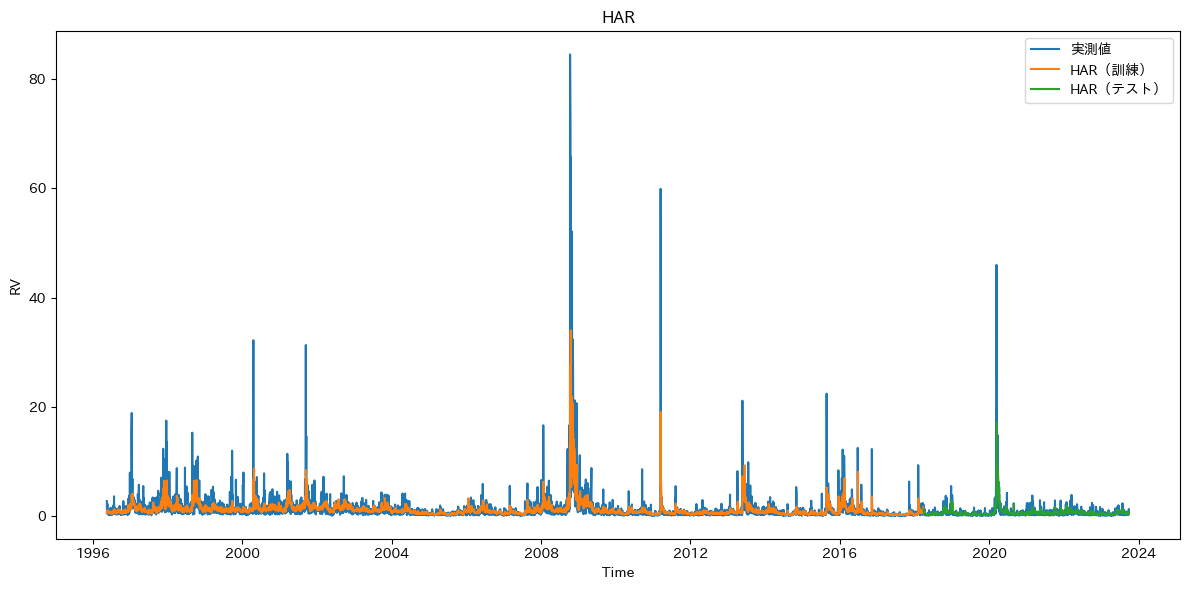

In [ ]:
plot_prediction_split(data=data, actual_col='30min', pred_col='HAR', test_ratio=test_ratio)

### LSTM

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
class LSTM(nn.Module):
    """
    LSTM でシーケンスを符号化し、最終時点の hidden state を
    全結合層でスカラーに変換して回帰予測を行うモデル。

    - seq_input: Tensor of shape (batch_size, seq_len, input_dim_seq)
    - returns: Tensor of shape (batch_size,)  (スカラー予測)
    """
    def __init__(
        self,
        input_dim_seq: int,
        hidden_dim: int = 64,
        num_layers: int = 1,
        dropout: float = 0.0
    ):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim_seq,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )
        # hidden_dim → 1（スカラー）
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, seq_input: torch.Tensor) -> torch.Tensor:
        # seq_input: (batch, seq_len, input_dim_seq)
        # h_n: (num_layers, batch, hidden_dim)
        _, (h_n, _) = self.lstm(seq_input)
        # 最終レイヤーの hidden state を取り出す
        last_hidden = h_n[-1]                 # shape: (batch, hidden_dim)
        out = self.fc(last_hidden).squeeze(1) # shape: (batch,)
        return out



In [ ]:
def prepare_features_LSTM(data: pd.DataFrame, embedding_flag: bool = False):
    """
    LSTMモデル用の系列特徴量と目的変数を作成する関数。

    Parameters:
    - data: pandas DataFrame,
        必須カラム ['log_5min', 'return_abs', 'return_abs_times_dummy'] を含む。
        その他に埋め込み列がある場合も可。
    - embedding_flag: bool,
        False: dynamic columns = ['log_5min', 'return_abs', 'return_abs_times_dummy']
        True : dynamic columns に加え、DataFrame中の埋め込み列（上記以外のすべて）も含める

    Returns:
    - X: numpy.ndarray, shape (n_samples, seq_len, n_features)
        seq_len=22, n_features = 3 or 3 + n_embed
    - y: numpy.ndarray, shape (n_samples,)
        目的変数は時点iの 'log_5min'

    Notes:
    - 先頭22行はサンプルに含めず、i=22から開始
    """
    # 必須カラムの欠損を排除
    base_cols = ['log_5min', 'return_abs', 'return_abs_times_dummy']
    # “dim_” で始まるカラムだけを抽出する
    embed_cols = [col for col in data.columns if col.startswith('dim_')]

    df = data.reset_index(drop=True).dropna(subset=base_cols+embed_cols)
    n = len(df)

    # 動的に利用する列リスト
    if embedding_flag:
        dynamic_cols = base_cols + embed_cols
    else:
        dynamic_cols = base_cols

    seq_len = 22
    X_list = []
    y_list = []
    for i in range(seq_len, n):
        seq_window = df[dynamic_cols].iloc[i-seq_len:i].values  # shape (seq_len, n_features)
        X_list.append(seq_window)
        y_list.append(df['log_5min'].iloc[i])

    X = np.stack(X_list)  # (n_samples, seq_len, n_features)
    y = np.array(y_list)

    return X, y


In [ ]:
def scaler_LSTM(
    X_train: np.ndarray,
    X_val: np.ndarray,
    X_test: np.ndarray,
    y_train: np.ndarray,
    y_val: np.ndarray,
    y_test: np.ndarray
):
    """
    LSTMモデル用の系列特徴量と目的変数を MinMaxScaler でスケーリングする関数。

    Args:
        X_train, X_val, X_test: numpy.ndarray, shape (N, seq_len, n_features)
        y_train, y_val, y_test: numpy.ndarray, shape (N,)

    Returns:
        X_train_s, X_val_s, X_test_s: numpy.ndarray, スケーリング後の系列特徴量
        y_train_s, y_val_s, y_test_s: numpy.ndarray, スケーリング後の目的変数
        inverse_y: callable, スケーリングされた y を元のスケールに戻す関数
    """
    # シーケンス特徴量のスケーリング
    _, seq_len, n_features = X_train.shape
    scaler_X = MinMaxScaler()
    # reshape to (N_train*seq_len, n_features)
    X_train_flat = X_train.reshape(-1, n_features)
    X_train_flat_s = scaler_X.fit_transform(X_train_flat)
    X_val_flat = X_val.reshape(-1, n_features)
    X_val_flat_s = scaler_X.transform(X_val_flat)
    X_test_flat = X_test.reshape(-1, n_features)
    X_test_flat_s = scaler_X.transform(X_test_flat)
    # reshape back
    X_train_s = X_train_flat_s.reshape(X_train.shape[0], seq_len, n_features)
    X_val_s   = X_val_flat_s.reshape(X_val.shape[0], seq_len, n_features)
    X_test_s  = X_test_flat_s.reshape(X_test.shape[0], seq_len, n_features)

    # 目的変数のスケーリング
    scaler_y = MinMaxScaler()
    y_train_s = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
    y_val_s   = scaler_y.transform(y_val.reshape(-1, 1)).flatten()
    y_test_s  = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

    # 逆変換関数
    def inverse_y(y_scaled: np.ndarray) -> np.ndarray:
        return scaler_y.inverse_transform(y_scaled.reshape(-1, 1)).flatten()

    return X_train_s, X_val_s, X_test_s, y_train_s, y_val_s, y_test_s, inverse_y


In [ ]:
def tune_model_LSTM(
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_val: np.ndarray,
    y_val: np.ndarray
) -> dict:
    """
    Optuna を用いて LSTM のハイパーパラメータチューニングを行う関数。
    device に応じてモデル／データを移動させるように修正済み。
    """
    def objective(trial):
        # チューニングするパラメータ
        hidden_dim = trial.suggest_int('hidden_dim', 32, 128)
        num_layers = trial.suggest_int('num_layers', 1, 3)
        batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
        lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)

        # DataLoader の準備
        train_dataset = TensorDataset(
            torch.tensor(X_train, dtype=torch.float32),
            torch.tensor(y_train, dtype=torch.float32)
        )
        val_dataset = TensorDataset(
            torch.tensor(X_val, dtype=torch.float32),
            torch.tensor(y_val, dtype=torch.float32)
        )
        train_loader = DataLoader(
            train_dataset, batch_size=batch_size, shuffle=True,
            pin_memory=True  # CUDA 時の転送を高速化
        )
        val_loader = DataLoader(
            val_dataset, batch_size=batch_size, shuffle=False,
            pin_memory=True
        )

        # モデル初期化＆ device へ移動
        input_dim_seq = X_train.shape[2]
        model = LSTM(
            input_dim_seq=input_dim_seq,
            hidden_dim=hidden_dim,
            num_layers=num_layers
        ).to(device)

        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        # 学習
        model.train()
        epochs = 50
        for _ in range(epochs):
            for X_batch, y_batch in train_loader:
                # デバイスへ転送
                X_batch = X_batch.to(device, non_blocking=True)
                y_batch = y_batch.to(device, non_blocking=True)
                optimizer.zero_grad()
                output = model(X_batch)
                loss = criterion(output, y_batch)
                loss.backward()
                optimizer.step()

        # 検証
        model.eval()
        total_val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch = X_batch.to(device, non_blocking=True)
                y_batch = y_batch.to(device, non_blocking=True)

                output = model(X_batch)
                total_val_loss += criterion(output, y_batch).item()

        return total_val_loss / len(val_loader)

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=20)
    return study.best_params


In [ ]:
def train_model_LSTM(
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_val: np.ndarray,
    y_val: np.ndarray,
    best_params: dict,
    device: torch.device = torch.device('cpu')
) -> nn.Module:
    """
    LSTMモデルを結合データで学習し、early stoppingを適用する関数。

    Args:
        X_train: numpy.ndarray, shape (N_train, seq_len, n_features)
        y_train: numpy.ndarray, shape (N_train,)
        X_val:   numpy.ndarray, shape (N_val,   seq_len, n_features)
        y_val:   numpy.ndarray, shape (N_val,)
        best_params: dict, {
            'hidden_dim': int,
            'num_layers': int,
            'batch_size': int,
            'lr': float
        }
        device: torch.device, モデル・データを配置するデバイス

    Returns:
        model: 学習済みのLSTMモデル
    """
    # 訓練データと検証データを結合
    X = np.concatenate([X_train, X_val], axis=0)
    y = np.concatenate([y_train, y_val], axis=0)

    # DataLoader の準備
    dataset = TensorDataset(
        torch.tensor(X, dtype=torch.float32),
        torch.tensor(y, dtype=torch.float32)
    )
    loader = DataLoader(
        dataset,
        batch_size=best_params['batch_size'],
        shuffle=False
    )

    # モデル定義
    input_dim_seq = X.shape[2]
    model = LSTM(
        input_dim_seq=input_dim_seq,
        hidden_dim=best_params['hidden_dim'],
        num_layers=best_params['num_layers']
    ).to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'])

    # early stopping
    epochs = 100
    patience = 10
    best_loss = float('inf')
    counter = 0

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output.squeeze(), y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(loader)
        if avg_loss < best_loss:
            best_loss = avg_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                break

    return model


In [ ]:
def predict_LSTM(model, X):
    """
    学習済みLSTMモデルで系列データから予測を行う関数。

    Args:
        model: torch.nn.Module, 学習済みLSTMモデル
        X: numpy.ndarray, shape (N, seq_len, n_features)

    Returns:
        numpy.ndarray: shape (N,), モデルの予測値
    """
    # モデルとデータを同じデバイス上に
    device = next(model.parameters()).device
    model.to(device)
    model.eval()

    # 入力データを TensorDataset & DataLoader に変換
    X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
    dummy_y = torch.zeros(X_tensor.size(0), dtype=torch.float32).to(device)
    dataset = TensorDataset(X_tensor, dummy_y)
    loader = DataLoader(dataset, batch_size=128, shuffle=False)

    predictions = []
    with torch.no_grad():
        for X_batch, _ in loader:
            # X_batch だけをモデルに渡す
            output = model(X_batch)
            predictions.extend(output.cpu().numpy().reshape(-1))

    return np.array(predictions)

In [ ]:
run_model_pipeline(data=data, embedding_flag=False, prepare_features_func=prepare_features_LSTM, val_ratio=val_ratio, test_ratio=test_ratio, scaler_func=scaler_LSTM, tune_model_func=tune_model_LSTM, train_model_func=train_model_LSTM, predict_func=predict_LSTM, model_name='LSTM')

[I 2025-05-14 10:29:51,830] A new study created in memory with name: no-name-b17969cc-fb7c-4867-a9f8-3bfbd2b0e7c3
[I 2025-05-14 10:32:35,777] Trial 0 finished with value: 0.009052714454897103 and parameters: {'hidden_dim': 68, 'num_layers': 3, 'batch_size': 32, 'lr': 0.00012757519910403176}. Best is trial 0 with value: 0.009052714454897103.
[I 2025-05-14 10:33:49,330] Trial 1 finished with value: 0.010280115729463952 and parameters: {'hidden_dim': 108, 'num_layers': 1, 'batch_size': 64, 'lr': 0.00010394478105743748}. Best is trial 0 with value: 0.009052714454897103.
[I 2025-05-14 10:38:26,126] Trial 2 finished with value: 0.008918669351953127 and parameters: {'hidden_dim': 98, 'num_layers': 3, 'batch_size': 32, 'lr': 0.0006322503447638196}. Best is trial 2 with value: 0.008918669351953127.
[I 2025-05-14 10:42:07,508] Trial 3 finished with value: 0.00884633752602068 and parameters: {'hidden_dim': 81, 'num_layers': 3, 'batch_size': 128, 'lr': 0.0013907237877525042}. Best is trial 3 with 

,5min,30min,log_5min,return,return_abs,return_dummy,return_abs_times_dummy,HAR,LSTM
date,,,,,,,,,
1996-03-11,1.50927,1.76196,0.411626,NaN,NaN,NaN,NaN,NaN,NaN
1996-03-12,0.48000,0.43200,-0.733969,NaN,NaN,NaN,NaN,NaN,NaN
1996-03-13,0.72100,0.91600,-0.327116,NaN,NaN,NaN,NaN,NaN,NaN
1996-03-14,0.48700,0.52000,-0.719491,NaN,NaN,NaN,NaN,NaN,NaN
1996-03-15,1.09568,0.71100,0.091375,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2023-09-25,0.21900,0.21100,-1.518684,0.848824,0.848824,0.0,0.000000,0.350130,0.397713
2023-09-26,0.36400,0.54600,-1.010601,-1.118798,1.118798,1.0,1.118798,0.274983,0.288800
2023-09-27,0.35200,0.28700,-1.044124,0.175770,0.175770,0.0,0.000000,0.376064,0.380732


In [ ]:
data.head(50)

,5min,30min,log_5min,return,return_abs,return_dummy,return_abs_times_dummy,HAR,LSTM
date,,,,,,,,,
1996-03-11,1.50927,1.76196,0.411626,NaN,NaN,NaN,NaN,NaN,NaN
1996-03-12,0.48000,0.43200,-0.733969,NaN,NaN,NaN,NaN,NaN,NaN
1996-03-13,0.72100,0.91600,-0.327116,NaN,NaN,NaN,NaN,NaN,NaN
1996-03-14,0.48700,0.52000,-0.719491,NaN,NaN,NaN,NaN,NaN,NaN
1996-03-15,1.09568,0.71100,0.091375,NaN,NaN,NaN,NaN,NaN,NaN
1996-03-18,0.66600,0.24400,-0.406466,NaN,NaN,NaN,NaN,NaN,NaN
1996-03-19,1.61955,0.92200,0.482148,NaN,NaN,NaN,NaN,NaN,NaN
1996-03-21,0.67600,0.93000,-0.391562,NaN,NaN,NaN,NaN,NaN,NaN
1996-03-22,0.78300,0.53600,-0.244623,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
evaluate_model(data=data, actual_col='30min', pred_col='LSTM', test_ratio=test_ratio, loss_name='MSE', loss_func=mean_squared_error)

1.9178265720235095

In [ ]:
evaluate_model(data=data, actual_col='30min', pred_col='LSTM', test_ratio=test_ratio, loss_name='Q-LIKE', loss_func=q_like)

np.float64(0.18452533406435506)

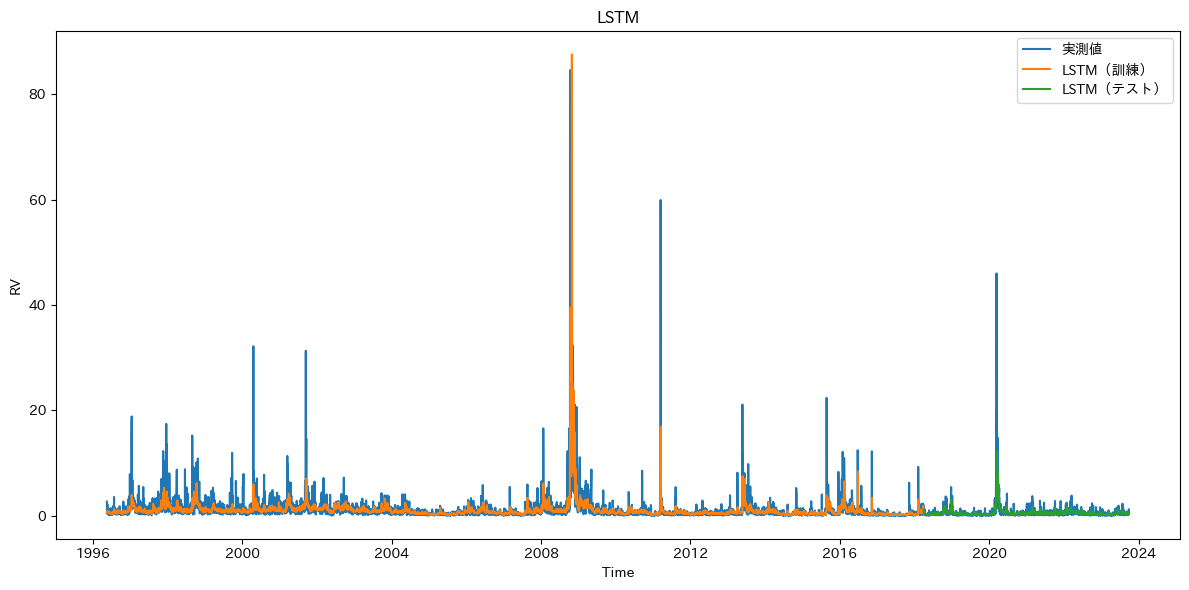

In [ ]:
plot_prediction_split(data=data, actual_col='30min', pred_col='LSTM', test_ratio=test_ratio)

### ランダムフォレスト

In [ ]:
def prepare_features_ML(data: pd.DataFrame, embedding_flag: bool = False):
    """
    機械学習モデル用の特徴量と目的変数を作成する関数。

    Parameters:
    - data: pandas DataFrame,
        必須カラム ['log_5min', 'return_abs', 'return_abs_times_dummy'] を含む。
        その他に埋め込み列がある場合も可。
    - embedding_flag: bool,
        False: 特徴量は過去22時点のlog_5min, return_abs, return_abs_times_dummyのラグ
        True : 上記に加え、DataFrame中の埋め込み列（除外リスト以外）の過去22時点の値も含める

    Returns:
    - X: numpy.ndarray, shape (n_samples, n_features)
        フラットな特徴量ベクトル
    - y: numpy.ndarray, shape (n_samples,)
        目的変数は時点iの 'log_5min'

    Notes:
    - 先頭22行はサンプルに含めず、i=22から開始
    - embedding_flag=True の場合、
      ['5min','30min','log_5min','return','return_abs','return_dummy','return_abs_times_dummy']
      を除く全ての列を埋め込み列とみなし、過去22時点分の値を追加します。
    """
    # 必須カラム欠損を排除
    base_cols = ['log_5min', 'return_abs', 'return_abs_times_dummy']
    # “dim_” で始まるカラムだけを抽出する
    embed_cols = [col for col in data.columns if col.startswith('dim_')]
    df = data.reset_index(drop=True).dropna(subset=base_cols+embed_cols)
    n = len(df)

    X_list = []
    y_list = []
    seq_len = 22
    for i in range(seq_len, n):
        # 過去22時点の log_5min
        past_vals = df['log_5min'].iloc[i-seq_len:i].values.tolist()
        # 過去22時点の return_abs ラグ
        return_abs_lags = df['return_abs'].iloc[i-seq_len:i].values.tolist()
        # 過去22時点の return_abs_times_dummy ラグ
        return_abs_times_dummy_lags = df['return_abs_times_dummy'].iloc[i-seq_len:i].values.tolist()

        # 基本特徴量ベクトルを結合
        features = past_vals + return_abs_lags + return_abs_times_dummy_lags

        if embedding_flag:
            # 埋め込み列群の過去22時点の値を追加
            for col in embed_cols:
                features.extend(df[col].iloc[i-seq_len:i].values.tolist())

        X_list.append(features)
        y_list.append(df['log_5min'].iloc[i])

    X = np.array(X_list, dtype=float)
    y = np.array(y_list, dtype=float)
    return X, y


In [ ]:
def scaler_ML(X_train, X_val, X_test, y_train, y_val, y_test):
    """
    特徴量と目的変数を MinMaxScaler でスケーリングする関数。
    目的変数の逆変換関数も返す。

    Args:
        X_train, X_val, X_test: 特徴量データ（辞書）
        y_train, y_val, y_test: 目的変数（1次元）

    Returns:
        X_train_scaled, X_val_scaled, X_test_scaled: スケーリングされた特徴量
        y_train_scaled, y_val_scaled, y_test_scaled: スケーリングされた目的変数
        inverse_y: スケーリングされた y を元に戻す関数
    """
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    X_train_scaled = scaler_X.fit_transform(X_train)
    X_val_scaled = scaler_X.transform(X_val)
    X_test_scaled = scaler_X.transform(X_test)

    y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
    y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1)).flatten()
    y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

    def inverse_y(y_scaled):
        """スケーリングされた目的変数を元に戻す関数"""
        return scaler_y.inverse_transform(y_scaled.reshape(-1, 1)).flatten()

    return (
        X_train_scaled,
        X_val_scaled,
        X_test_scaled,
        y_train_scaled,
        y_val_scaled,
        y_test_scaled,
        inverse_y
    )


In [ ]:
def tune_model_RF(X_train, y_train, X_val, y_val):
    """
    Optuna を用いてランダムフォレストのハイパーパラメータチューニングを行う関数。

    Args:
        X_train (ndarray): スケーリング済みの訓練特徴量
        y_train (ndarray): スケーリング済みの訓練目的変数
        X_val (ndarray): スケーリング済みの検証特徴量
        y_val (ndarray): スケーリング済みの検証目的変数

    Returns:
        best_params (dict): 最適なハイパーパラメータ
    """

    def objective(trial):
        # 探索するハイパーパラメータ
        n_estimators = trial.suggest_int("n_estimators", 50, 500, step=50)
        max_depth = trial.suggest_categorical("max_depth", [10, 20, 30, 40, 50, None])
        min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
        min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)

        # モデルの作成
        model = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            random_state=42,
            n_jobs=-1
        )

        # 学習と予測
        model.fit(X_train, y_train)
        y_val_pred = model.predict(X_val)

        # MSE を返す（最小化対象）
        return mean_squared_error(y_val, y_val_pred)

    # Optuna の study を作成して最適化を実行
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=20)

    return study.best_params


In [ ]:
def train_model_RF(X_train, y_train, X_val, y_val, best_params):
    """
    RandomForestRegressor を train + val データで学習する関数。

    Args:
        X_train (ndarray): 訓練データの特徴量
        y_train (ndarray): 訓練データの目的変数
        X_val (ndarray): 検証データの特徴量
        y_val (ndarray): 検証データの目的変数
        best_params (dict): Optuna などで得た最適なハイパーパラメータ

    Returns:
        model (RandomForestRegressor): 学習済みモデル
    """

    # 訓練データと検証データを結合して学習用データを作成
    X_trainval = np.concatenate([X_train, X_val], axis=0)
    y_trainval = np.concatenate([y_train, y_val], axis=0)

    # モデルの作成と学習
    model = RandomForestRegressor(**best_params, random_state=42, n_jobs=-1)
    model.fit(X_trainval, y_trainval)

    return model

In [ ]:
def predict_ML(model, X):
    """
    学習済み RandomForest モデルで予測を行う関数。

    Args:
        model (RandomForestRegressor): 学習済みモデル
        X (ndarray): 予測に使う特徴量

    Returns:
        y_pred (ndarray): モデルによる予測結果（スケールされた状態）
    """
    return model.predict(X)

In [ ]:
run_model_pipeline(data=data, embedding_flag=False, prepare_features_func=prepare_features_ML, val_ratio=val_ratio, test_ratio=test_ratio, scaler_func=scaler_ML, tune_model_func=tune_model_RF, train_model_func=train_model_RF, predict_func=predict_ML, model_name='RF')

[I 2025-05-14 11:27:50,967] A new study created in memory with name: no-name-10676945-eb37-4a4f-a77d-f21462fe086c
[I 2025-05-14 11:28:42,607] Trial 0 finished with value: 0.00934225471896021 and parameters: {'n_estimators': 400, 'max_depth': 50, 'min_samples_split': 17, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.00934225471896021.
[I 2025-05-14 11:29:39,746] Trial 1 finished with value: 0.009362379659830064 and parameters: {'n_estimators': 400, 'max_depth': 40, 'min_samples_split': 13, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.00934225471896021.
[I 2025-05-14 11:30:17,334] Trial 2 finished with value: 0.009368227110313645 and parameters: {'n_estimators': 250, 'max_depth': None, 'min_samples_split': 7, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.00934225471896021.
[I 2025-05-14 11:30:36,379] Trial 3 finished with value: 0.009312291742388455 and parameters: {'n_estimators': 150, 'max_depth': 50, 'min_samples_split': 3, 'min_samples_leaf': 10}. Best is tri

,5min,30min,log_5min,return,return_abs,return_dummy,return_abs_times_dummy,HAR,LSTM,RF
date,,,,,,,,,,
1996-03-11,1.50927,1.76196,0.411626,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-03-12,0.48000,0.43200,-0.733969,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-03-13,0.72100,0.91600,-0.327116,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-03-14,0.48700,0.52000,-0.719491,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-03-15,1.09568,0.71100,0.091375,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2023-09-25,0.21900,0.21100,-1.518684,0.848824,0.848824,0.0,0.000000,0.350130,0.397713,0.325021
2023-09-26,0.36400,0.54600,-1.010601,-1.118798,1.118798,1.0,1.118798,0.274983,0.288800,0.276662
2023-09-27,0.35200,0.28700,-1.044124,0.175770,0.175770,0.0,0.000000,0.376064,0.380732,0.397129


In [ ]:
data.head(50)

,5min,30min,log_5min,return,return_abs,return_dummy,return_abs_times_dummy,HAR,LSTM,RF
date,,,,,,,,,,
1996-03-11,1.50927,1.76196,0.411626,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-03-12,0.48000,0.43200,-0.733969,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-03-13,0.72100,0.91600,-0.327116,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-03-14,0.48700,0.52000,-0.719491,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-03-15,1.09568,0.71100,0.091375,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-03-18,0.66600,0.24400,-0.406466,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-03-19,1.61955,0.92200,0.482148,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-03-21,0.67600,0.93000,-0.391562,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-03-22,0.78300,0.53600,-0.244623,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
evaluate_model(data=data, actual_col='30min', pred_col='RF', test_ratio=test_ratio, loss_name='MSE', loss_func=mean_squared_error)

2.0420058081179087

In [ ]:
evaluate_model(data=data, actual_col='30min', pred_col='RF', test_ratio=test_ratio, loss_name='Q-LIKE', loss_func=q_like)

np.float64(0.1968182479960924)

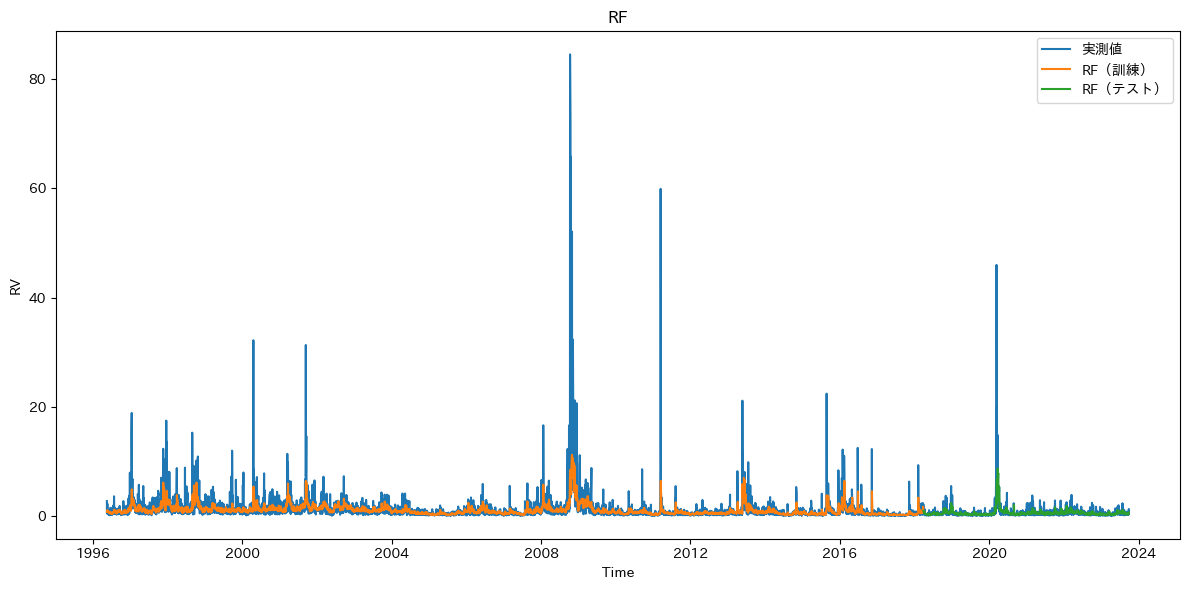

In [ ]:
plot_prediction_split(data=data, actual_col='30min', pred_col='RF', test_ratio=test_ratio)

## XGBoost

In [ ]:
def tune_model_XGB(X_train, y_train, X_val, y_val):
    """
    Optuna を用いて XGBoost のハイパーパラメータチューニングを行う関数。

    Args:
        X_train (ndarray): スケーリング済みの訓練特徴量
        y_train (ndarray): スケーリング済みの訓練目的変数
        X_val (ndarray): スケーリング済みの検証特徴量
        y_val (ndarray): スケーリング済みの検証目的変数

    Returns:
        best_params (dict): 最適なハイパーパラメータ
    """

    def objective(trial):
        # 探索するハイパーパラメータ
        n_estimators = trial.suggest_int("n_estimators", 50, 500, step=50)
        max_depth = trial.suggest_int("max_depth", 3, 15)
        learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True)
        gamma = trial.suggest_float("gamma", 0.0, 5.0)
        min_child_weight = trial.suggest_int("min_child_weight", 1, 50)
        colsample_bytree = trial.suggest_float("colsample_bytree", 0.5, 1.0)
        subsample = trial.suggest_float("subsample", 0.5, 1.0)

        # モデルの作成
        model = xgb.XGBRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            gamma=gamma,
            min_child_weight=min_child_weight,
            colsample_bytree=colsample_bytree,
            subsample=subsample,
            random_state=42,
            n_jobs=-1,
            verbosity=0
        )

        # モデルの学習と評価
        model.fit(X_train, y_train)
        y_val_pred = model.predict(X_val)
        return mean_squared_error(y_val, y_val_pred)

    # チューニング実行
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=20)

    return study.best_params

In [ ]:
def train_model_XGB(X_train, y_train, X_val, y_val, best_params):
    """
    XGBoost を train + val データで学習する関数。

    Args:
        X_train (ndarray): 訓練データの特徴量
        y_train (ndarray): 訓練データの目的変数
        X_val (ndarray): 検証データの特徴量
        y_val (ndarray): 検証データの目的変数
        best_params (dict): Optuna などで得た最適なハイパーパラメータ

    Returns:
        model (XGBoost): 学習済みモデル
    """

    # 訓練データと検証データを結合して学習用データを作成
    X_trainval = np.concatenate([X_train, X_val], axis=0)
    y_trainval = np.concatenate([y_train, y_val], axis=0)

    # モデルの作成と学習
    model = xgb.XGBRegressor(**best_params, random_state=42, n_jobs=-1)
    model.fit(X_trainval, y_trainval)

    return model

In [ ]:
run_model_pipeline(data=data, embedding_flag=False, prepare_features_func=prepare_features_ML, val_ratio=val_ratio, test_ratio=test_ratio, scaler_func=scaler_ML, tune_model_func=tune_model_XGB, train_model_func=train_model_XGB, predict_func=predict_ML, model_name='XGB')

[I 2025-05-14 11:47:54,501] A new study created in memory with name: no-name-9a320a67-5fd4-4f45-8876-75b3aa9ba86e
[I 2025-05-14 11:47:56,808] Trial 0 finished with value: 0.016084694627018496 and parameters: {'n_estimators': 350, 'max_depth': 15, 'learning_rate': 0.005727625131986227, 'gamma': 2.1178619103113148, 'min_child_weight': 17, 'colsample_bytree': 0.90281145008045, 'subsample': 0.607884765685885}. Best is trial 0 with value: 0.016084694627018496.
[I 2025-05-14 11:47:57,755] Trial 1 finished with value: 0.029921268418910945 and parameters: {'n_estimators': 300, 'max_depth': 9, 'learning_rate': 0.0004886970604108451, 'gamma': 0.9408038261920276, 'min_child_weight': 37, 'colsample_bytree': 0.586847226279394, 'subsample': 0.5782049686791408}. Best is trial 0 with value: 0.016084694627018496.
[I 2025-05-14 11:47:58,119] Trial 2 finished with value: 0.032979644745626355 and parameters: {'n_estimators': 100, 'max_depth': 12, 'learning_rate': 0.00041393009309382477, 'gamma': 4.2239765

,5min,30min,log_5min,return,return_abs,return_dummy,return_abs_times_dummy,HAR,LSTM,RF,XGB
date,,,,,,,,,,,
1996-03-11,1.50927,1.76196,0.411626,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-03-12,0.48000,0.43200,-0.733969,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-03-13,0.72100,0.91600,-0.327116,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-03-14,0.48700,0.52000,-0.719491,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-03-15,1.09568,0.71100,0.091375,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2023-09-25,0.21900,0.21100,-1.518684,0.848824,0.848824,0.0,0.000000,0.350130,0.397713,0.325021,0.388415
2023-09-26,0.36400,0.54600,-1.010601,-1.118798,1.118798,1.0,1.118798,0.274983,0.288800,0.276662,0.319092
2023-09-27,0.35200,0.28700,-1.044124,0.175770,0.175770,0.0,0.000000,0.376064,0.380732,0.397129,0.403231


In [ ]:
evaluate_model(data=data, actual_col='30min', pred_col='XGB', test_ratio=test_ratio, loss_name='MSE', loss_func=mean_squared_error)

1.8545014254072762

In [ ]:
evaluate_model(data=data, actual_col='30min', pred_col='XGB', test_ratio=test_ratio, loss_name='Q-LIKE', loss_func=q_like)

np.float64(0.1854159513432389)

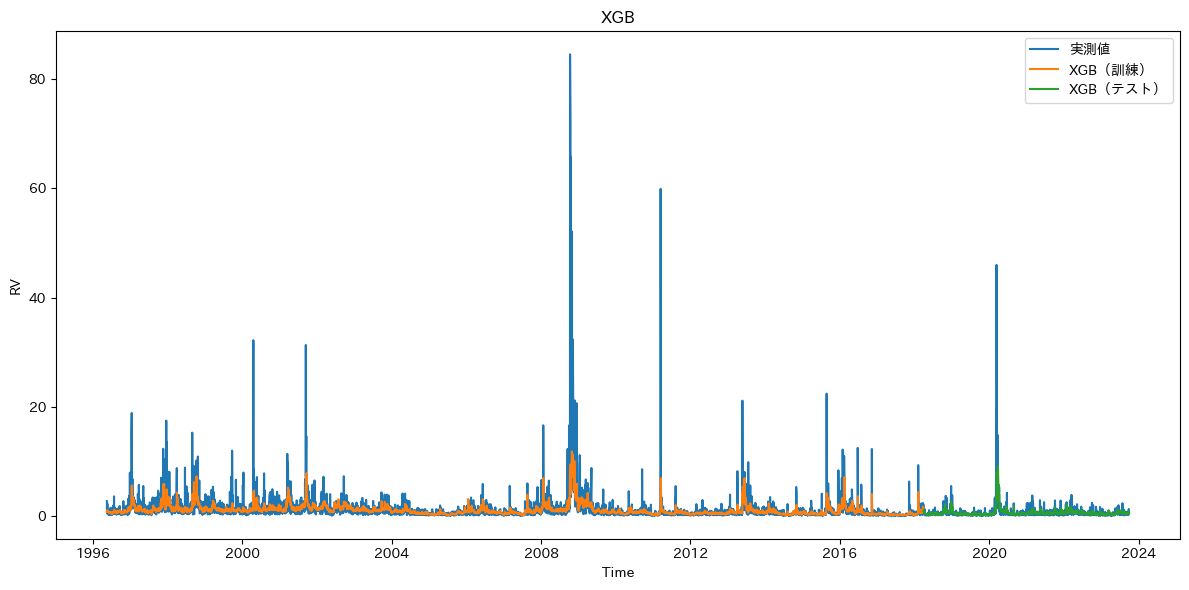

In [ ]:
plot_prediction_split(data=data, actual_col='30min', pred_col='XGB', test_ratio=test_ratio)

### LightGBM

In [ ]:
def tune_model_LGBM(X_train, y_train, X_val, y_val):
    """
    Optuna を用いて LightGBM のハイパーパラメータチューニングを行う関数。

    Args:
        X_train (ndarray): スケーリング済みの訓練特徴量
        y_train (ndarray): スケーリング済みの訓練目的変数
        X_val (ndarray): スケーリング済みの検証特徴量
        y_val (ndarray): スケーリング済みの検証目的変数

    Returns:
        best_params (dict): 最適なハイパーパラメータ
    """

    def objective(trial):
        # ハイパーパラメータ空間の定義
        n_estimators = trial.suggest_int("n_estimators", 50, 500, step=50)
        max_depth = trial.suggest_int("max_depth", 3, 15)
        learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True)
        num_leaves = trial.suggest_int("num_leaves", 20, 100)
        min_data_in_leaf = trial.suggest_int("min_data_in_leaf", 5, 50, step=1)

        # モデルの作成
        model = lgb.LGBMRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            num_leaves=num_leaves,
            min_data_in_leaf=min_data_in_leaf,
            random_state=42,
            n_jobs=-1,
            verbose=-1
        )

        # モデルの学習と評価
        model.fit(X_train, y_train)
        y_val_pred = model.predict(X_val)
        return mean_squared_error(y_val, y_val_pred)

    # Optunaのログ非表示（必要に応じて）
    optuna.logging.set_verbosity(optuna.logging.WARNING)

    # チューニング実行
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=20)

    return study.best_params


In [ ]:
def train_model_LGBM(X_train, y_train, X_val, y_val, best_params):
    """
    LightGBMを train + val データで学習する関数。

    Args:
        X_train (ndarray): 訓練データの特徴量
        y_train (ndarray): 訓練データの目的変数
        X_val (ndarray): 検証データの特徴量
        y_val (ndarray): 検証データの目的変数
        best_params (dict): Optuna などで得た最適なハイパーパラメータ

    Returns:
        model (LightGBM): 学習済みモデル
    """

    # 訓練データと検証データを結合して学習用データを作成
    X_trainval = np.concatenate([X_train, X_val], axis=0)
    y_trainval = np.concatenate([y_train, y_val], axis=0)

    # モデルの作成と学習
    model = lgb.LGBMRegressor(**best_params, random_state=42, n_jobs=-1)
    model.fit(X_trainval, y_trainval)

    return model

In [ ]:
run_model_pipeline(data=data, embedding_flag=False, prepare_features_func=prepare_features_ML, val_ratio=val_ratio, test_ratio=test_ratio, scaler_func=scaler_ML, tune_model_func=tune_model_LGBM, train_model_func=train_model_LGBM, predict_func=predict_ML, model_name='LGBM')

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

,5min,30min,log_5min,return,return_abs,return_dummy,return_abs_times_dummy,HAR,LSTM,RF,XGB,LGBM
date,,,,,,,,,,,,
1996-03-11,1.50927,1.76196,0.411626,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-03-12,0.48000,0.43200,-0.733969,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-03-13,0.72100,0.91600,-0.327116,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-03-14,0.48700,0.52000,-0.719491,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-03-15,1.09568,0.71100,0.091375,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-25,0.21900,0.21100,-1.518684,0.848824,0.848824,0.0,0.000000,0.350130,0.397713,0.325021,0.388415,0.338556
2023-09-26,0.36400,0.54600,-1.010601,-1.118798,1.118798,1.0,1.118798,0.274983,0.288800,0.276662,0.319092,0.318971
2023-09-27,0.35200,0.28700,-1.044124,0.175770,0.175770,0.0,0.000000,0.376064,0.380732,0.397129,0.403231,0.478177


In [ ]:
evaluate_model(data=data, actual_col='30min', pred_col='LGBM', test_ratio=test_ratio, loss_name='MSE', loss_func=mean_squared_error)

1.8753832844233191

In [ ]:
evaluate_model(data=data, actual_col='30min', pred_col='LGBM', test_ratio=test_ratio, loss_name='Q-LIKE', loss_func=q_like)

np.float64(0.1932119975365204)

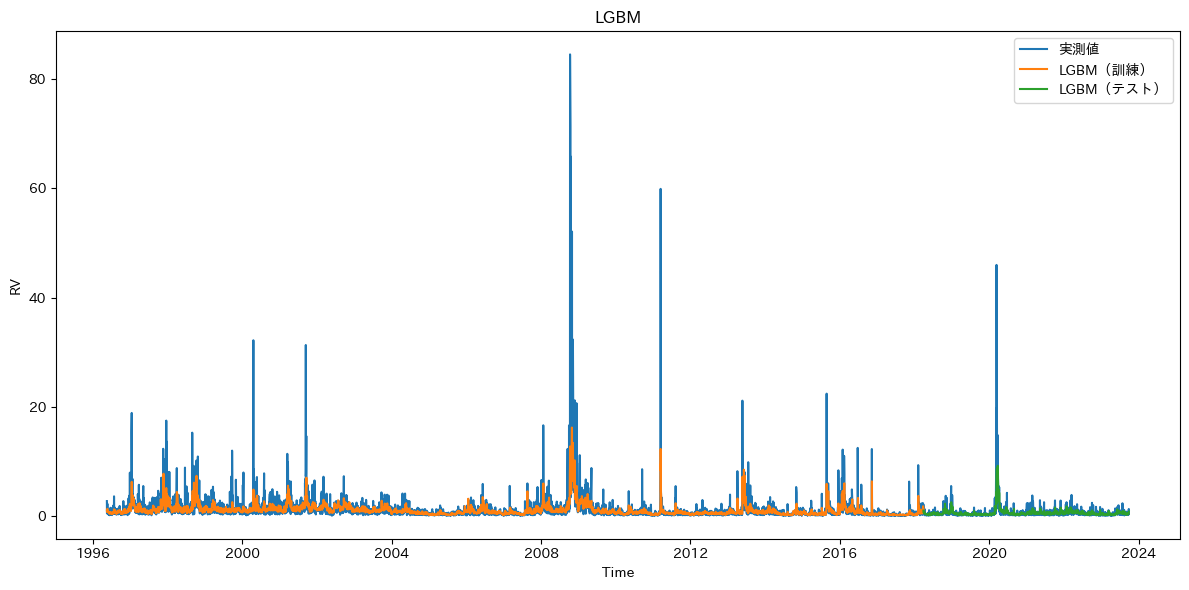

In [ ]:
plot_prediction_split(data=data, actual_col='30min', pred_col='LGBM', test_ratio=test_ratio)

## モデル評価・比較

In [ ]:
for model, scores in model_scores.items():
    print(f"{model}: MSE = {scores['MSE']}, Q-LIKE = {scores['Q-LIKE']}")

HAR: MSE = 1.998928851965296, Q-LIKE = 0.19276029130377778
LSTM: MSE = 1.9178265720235095, Q-LIKE = 0.18452533406435506
RF: MSE = 2.0420058081179087, Q-LIKE = 0.1968182479960924
XGB: MSE = 1.8545014254072762, Q-LIKE = 0.1854159513432389
LGBM: MSE = 1.8753832844233191, Q-LIKE = 0.1932119975365204


In [ ]:
data

,5min,30min,log_5min,return,return_abs,return_dummy,return_abs_times_dummy,HAR,LSTM,RF,XGB,LGBM
date,,,,,,,,,,,,
1996-03-11,1.50927,1.76196,0.411626,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-03-12,0.48000,0.43200,-0.733969,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-03-13,0.72100,0.91600,-0.327116,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-03-14,0.48700,0.52000,-0.719491,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-03-15,1.09568,0.71100,0.091375,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-25,0.21900,0.21100,-1.518684,0.848824,0.848824,0.0,0.000000,0.350130,0.397713,0.325021,0.388415,0.338556
2023-09-26,0.36400,0.54600,-1.010601,-1.118798,1.118798,1.0,1.118798,0.274983,0.288800,0.276662,0.319092,0.318971
2023-09-27,0.35200,0.28700,-1.044124,0.175770,0.175770,0.0,0.000000,0.376064,0.380732,0.397129,0.403231,0.478177


In [ ]:
def plot_model_predictions_split_grid(
    data,
    actual_col: str,
    model_cols: list,
    test_ratio: float,
    nrows: int,
    ncols: int
):
    """
    複数モデルの予測値をグリッド状にプロットし、訓練・テスト期間を色分けする関数。

    Parameters:
    - data: pandas.DataFrame, 実測値と予測値を含む
    - actual_col: str, 実測値のカラム名
    - model_cols: list of str, 予測モデルのカラム名リスト
    - test_ratio: float, テスト期間の割合 (0 < test_ratio < 1)
    - nrows: int, サブプロットの行数
    - ncols: int, サブプロットの列数
    """
    # 実測値とモデル予測のNaN除去
    used_cols = [actual_col] + model_cols
    df = data[used_cols].dropna()
    idx = df.index

    # 訓練/テストの分割インデックス
    total = len(idx)
    split = int(total * (1 - test_ratio))
    train_idx = idx[:split]
    test_idx = idx[split:]

    # サブプロット作成
    fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows), sharex=True)
    axes = np.array(axes).flatten()

    for i, model in enumerate(model_cols):
        if i >= nrows * ncols:
            break
        ax = axes[i]
        # 実測値
        ax.plot(idx, df[actual_col], label='実測値')
        # 訓練期間の予測
        ax.plot(train_idx, df.loc[train_idx, model], label=f'{model} (train)')
        # テスト期間の予測（強調）
        ax.plot(test_idx, df.loc[test_idx, model], label=f'{model} (test)')
        ax.set_title(model)
        ax.legend(loc='upper right', fontsize='small')

    # 余った軸は非表示
    for j in range(len(model_cols), nrows*ncols):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()


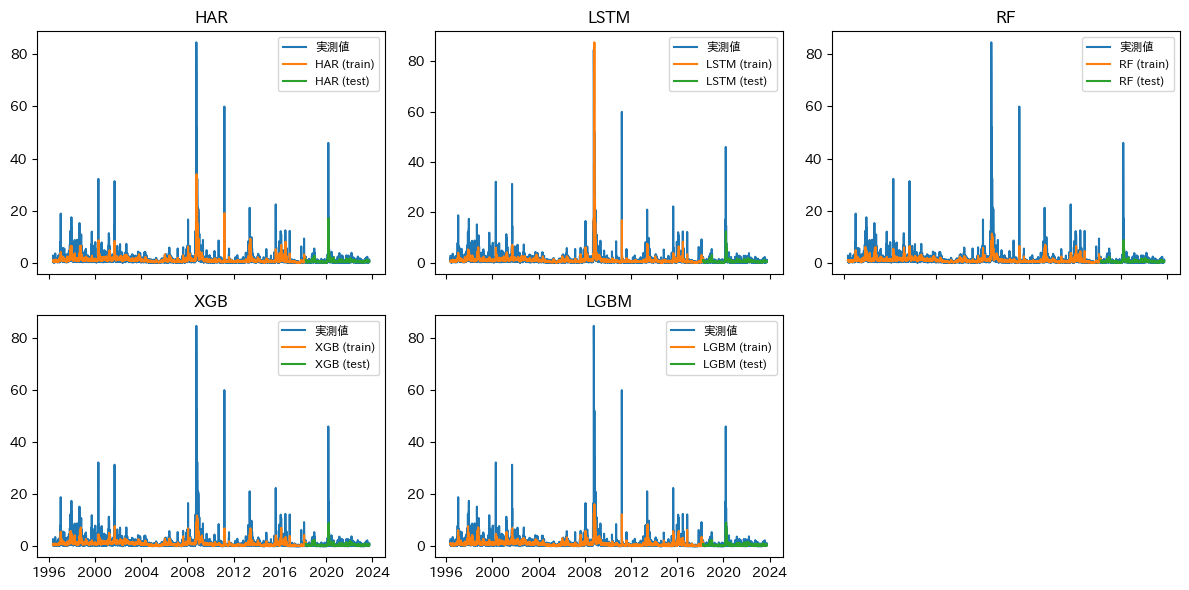

In [ ]:
plot_model_predictions_split_grid(
    data=data,
    actual_col='30min',
    model_cols=['HAR', 'LSTM', 'RF', 'XGB', 'LGBM'],
    test_ratio=test_ratio,
    nrows=2,
    ncols=3
)

In [ ]:
#実測値の列と予測値の列ののみ抽出
prediction = data[['30min', 'HAR', 'LSTM', 'RF', 'XGB', 'LGBM']]
prediction = prediction.dropna()

# ファイルに出力
#prediction.to_csv("prediction.csv", index=False)

In [ ]:
prediction

,30min,HAR,LSTM,RF,XGB,LGBM
date,,,,,,
1996-05-15,2.68351,0.524779,0.542747,0.740087,0.711242,0.929235
1996-05-16,0.41900,0.888442,0.779523,0.840721,0.725803,0.727525
1996-05-17,0.66200,0.715824,0.696267,0.706507,0.687255,0.731888
1996-05-20,2.18472,0.822293,0.774649,1.039809,1.026377,1.266088
1996-05-21,1.34698,0.979616,0.885146,0.821380,0.808902,0.792870
...,...,...,...,...,...,...
2023-09-25,0.21100,0.350130,0.397713,0.325021,0.388415,0.338556
2023-09-26,0.54600,0.274983,0.288800,0.276662,0.319092,0.318971
2023-09-27,0.28700,0.376064,0.380732,0.397129,0.403231,0.478177


In [ ]:
idx = prediction.index

# テスト開始位置を計算
n = len(idx)
split_at = int(n * (1 - test_ratio))

# テスト用インデックス
test_idx = idx[split_at:]

# 元のデータからテスト部分を抽出
test_data = prediction.loc[test_idx].copy()

In [ ]:
# 実測値の列名をユーザーに入力させる
actual_col = input("実測値の列名を入力してください: ")

実測値の列名を入力してください: 30min


In [ ]:
# 実測値以外の列を予測値とする
pred_cols = [col for col in test_data.columns if col != actual_col]

In [ ]:
# MSE の計算
loss_mse = pd.DataFrame({
    col: (test_data[col] - test_data[actual_col]) ** 2 for col in pred_cols
})

loss_mse.to_csv('loss_mse.csv', index=False)

In [ ]:
# QLIKE の計算: log(予測値) + 実測値 / 予測値
loss_qlike = pd.DataFrame({
    col: np.log(test_data[col]) + (test_data[actual_col] / test_data[col]) for col in pred_cols
})

loss_qlike.to_csv('loss_qlike.csv', index=False)